In [1]:
import csv
import numpy as np
import sklearn
import random
import sklearn.linear_model

/home/ethanid/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
mapper = {}

with open("./states.csv", 'r') as blah:
    for line in csv.reader(blah):
        mapper[line[0]] = line[1]
        
print(mapper)

{'State': 'Abbreviation', 'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}


In [3]:
from collections import defaultdict

state_policies = defaultdict(set)

with open("./PolicyBreakdownByState.csv", 'r') as blah:
    policy_lines = list(csv.reader(blah))
    
    legend = policy_lines[0]
    
    for line in policy_lines[1:]:
        for item, typ in zip(line[1:], legend[1:]):
            if item == '1':
                state_policies[typ].add(mapper[line[0]])

print(state_policies)

defaultdict(<class 'set'>, {'Governance': {'CT', 'FL', 'DE', 'RI', 'WV', 'GA', 'LA', 'IL', 'KY', 'MT', 'OH', 'TN', 'AL', 'NH', 'UT'}, 'Monitoring': {'FL', 'LA', 'TX', 'TN', 'VT', 'UT', 'CT', 'RI', 'ID', 'DE', 'MD', 'NY', 'VA', 'WA', 'NJ', 'OH', 'IN', 'NC', 'ME', 'CO', 'CA'}, 'Naloxone': {'FL', 'GA', 'OK', 'LA', 'TX', 'TN', 'UT', 'CT', 'OR', 'DE', 'MD', 'NY', 'WA', 'KY', 'NJ', 'OH', 'ME', 'CO', 'WI', 'CA', 'MN'}, 'Investigation': {'FL', 'VA', 'WV', 'CO', 'MA', 'CA', 'NH', 'UT'}, 'Quantity control': {'ME', 'OK', 'IL', 'CO', 'MT', 'OH', 'MA', 'UT'}, 'Education': {'OR', 'ME', 'IL', 'TX', 'NM', 'MA', 'OH', 'ID', 'UT'}})


In [4]:
SURPRESSED_DEATH_INPUTATION = 0

county_death_rate = {}

with open('./deathData.txt', 'r') as foo:
    lines = list(csv.reader(foo, delimiter='\t'))
    
    header = lines[0]
    
    for line in lines[1:]:
        if line[0] == '---':
            break
        _, name, number, year, year_number, deaths, population, _ = line
        if year != '2016':
            continue

        if deaths == 'Missing':
            pass
        elif deaths == 'Suppressed':
            county_death_rate[name] = SURPRESSED_DEATH_INPUTATION
        else:
            county_death_rate[name] = int(deaths) / int(population)



In [5]:
with open("./2014 CHR analytic data.csv", 'r') as foo:
    lines = list(csv.reader(foo))
    
first = lines[0]
second = lines[1]

fields = [(i, name, desc) for i, (name, desc) in enumerate(zip(first, second)) if name.startswith('measure_') and name.endswith('value')]

county_lines = lines[2:]
random.shuffle(county_lines)

In [187]:
data = []
meta_labels = []
death_labels = []
final_labels = defaultdict(list)
        
for line in county_lines:
    state, county = line[2], line[3]
    full_county = '{}, {}'.format(county, state)
    
    if full_county not in county_death_rate:
        continue
    data_row = []
    for i, _, _ in fields:
        text_value = line[i]
        if text_value == '':
            data_row.append(np.nan)
        else:
            data_row.append(float(text_value.replace(',', '')))
    data.append(data_row)
    meta_labels.append((state, county))
    death_labels.append(county_death_rate[full_county])
    
    for policy, set_good in state_policies.items():
        if state in set_good:
            final_labels[policy].append(1)
        else:
            final_labels[policy].append(0)
        
data = np.array(data)

In [192]:
def get_matching_pairs(values, labels, caliper = 0.05):
    val_zeros = []
    val_ones = []
    
    for i, (val, lab) in enumerate(zip(values, labels)):
        if lab == 0:
            val_zeros.append((val, i))
        else:
            val_ones.append((val, i))
            
    random.shuffle(val_ones)
    random.shuffle(val_zeros)
            
    used_controls = set()
    
    matched_zeros = []
    matched_ones = []
    
    for val_to_match, index_to_match in val_ones:
        current_best = None
        
        for other_val, other_index in val_zeros:
            if other_index in used_controls:
                continue
                
            dist = abs(val_to_match - other_val)
            
            if dist > caliper:
                continue
                
            if current_best is None or dist < current_best[0]:
                current_best = dist, other_index
        
        if current_best is not None:
            used_controls.add(current_best[1])
            matched_ones.append(index_to_match)
            matched_zeros.append(current_best[1])
        
    return matched_zeros, matched_ones

def compute_estimates(X, labels, death):
    shuffle_X, shuffle_labels, shuffle_death = sklearn.utils.shuffle(X, labels, death)
    
    params = {
        'learning_rate': 0.1, 
        'max_depth': 6, 
        'min_child_weight': 1, 
        'n_estimators': 200, 
        'objective': 'binary:logistic'
    }
    
    final_probs = np.zeros(len(labels))

    kf = sklearn.model_selection.KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        model = xgb.XGBClassifier(**params)
        model.fit(X[train_index,:], np.array(labels)[train_index])
        
        final_probs[test_index] = model.predict_proba(X[test_index, :])[:,1]
        
    no_policy, policy = get_matching_pairs(final_probs, labels)
    
    print(len(no_policy))
    
    no_policy_death = np.array(death)[no_policy]
    policy_death = np.array(death)[policy]

    estimated_effect = np.mean(policy_death) - np.mean(no_policy_death)

    return estimated_effect * 100 * 1000, final_probs

In [193]:
point_estimates = {}
all_propensity_scores = {}

for policy, labels in final_labels.items():
    print(policy)
    point_estimate, propensity_scores = compute_estimates(data, labels, death_labels)
    
    print(point_estimate)
    point_estimates[policy] = point_estimate
    all_propensity_scores[policy] = propensity_scores

Governance
233
0.64021797392
Monitoring
295
-0.889516583679
Naloxone
338
0.424631823887
Investigation
148
0.541323165692
Quantity control
122
1.35150004876
Education
111
0.0994779881984


In [194]:
bootstrap_estimates = {}

for policy, labels in final_labels.items():
    print(policy)
    bootstraps = []
    for i in range(20):
        sub_X, sub_labels, sub_death = sklearn.utils.resample(data, labels, death_labels)
        bootstraps.append(compute_estimates(sub_X, sub_labels, sub_death)[0])
    bootstrap_estimates[policy] = bootstraps
    print(bootstraps)

Governance
123
121
131
118
107
113
106
107
112
111
125
110
117
106
118
104
126
114
102
107
[0.18405837058979704, 1.061559233485432, -0.64322010424924503, -1.0792530060472347, 1.4109549771379717, -0.12249544231660833, -0.63869899891157933, -0.8368378721098263, -1.5152457170587446, -4.008889076937991, -3.3655396241024711, 0.17696496740795511, -0.24281796339262754, -1.7292974136868442, -1.6202877814517289, -3.0608637028786361, 0.37612449408038934, -1.3034815949431688, 1.8608691230765129, 1.1403666983671581]
Monitoring
153
168
173
152
162
143
162
158
152
167
159
154
162
174
149
161
166
163
163
188
[0.026224990203849403, -1.969985981578499, -0.54263121287631555, 1.2572674231090244, -1.4399183077444762, -0.22390974897926907, -0.96539551651537814, -0.93869501849528492, -0.017581655492273543, -0.33468965851036775, -0.64741325302413855, -1.9464547543947415, -5.1860502070762466, -0.65712982464834879, -2.6481580305804462, -2.9363449997629245, -1.2573630953230732, -0.24780841690747579, -0.37242282

In [121]:
%matplotlib inline

import matplotlib.pyplot as plt

for policy, labels in final_labels.items():

    first_ones = []
    second_ones = []

    for label,prob in zip(labels, all_propensity_scores[policy]):
        if label == 0:
                continue
            first_ones.append(prob)
        else:
            if prob > 0.8:
                continue
            second_ones.append(prob)
            
    bins = np.linspace(0, 1, 20)

    print(probs, len(first_ones), len(second_ones))
    plt.title('Propensity Model For {}'.format(policy))
    plt.ylabel('Number Of Counties With Probability')
    plt.xlabel('Probability Of Policy')
    plt.hist(first_ones, bins, alpha=0.5, label='No Policy')
    plt.hist(second_ones, bins, alpha=0.5, label='Policy')
    plt.legend(loc='upper right')
    plt.savefig('{}_propensity.png'.format(policy))
    plt.clf()
    
    break

[ 0.50135237  0.53812701  0.02462141 ...,  0.08062439  0.41923127
  0.13592051] 163 281


[0.64021797392013158, -0.8895165836788802, 0.42463182388729165, 0.54132316569178884, 1.3515000487566213, 0.09947798819844017]
[0.18405837058979704, 1.061559233485432, -0.64322010424924503, -1.0792530060472347, 1.4109549771379717, -0.12249544231660833, -0.63869899891157933, -0.8368378721098263, -1.5152457170587446, -4.008889076937991, -3.3655396241024711, 0.17696496740795511, -0.24281796339262754, -1.7292974136868442, -1.6202877814517289, -3.0608637028786361, 0.37612449408038934, -1.3034815949431688, 1.8608691230765129, 1.1403666983671581]
['Governance', 'Monitoring', 'Naloxone', 'Investigation', 'Quantity control', 'Education']
[-2.4503717434206074, -2.0247051886624501, -1.807130719819863, -2.2267903932889439, -3.1127425892713689, -1.4226026030153607]
[-1.808385077824652, -0.78579197637688947, -2.1294382027039673, -1.955444208106127, -3.9130690890077204, -4.105550982153213]
[-0.64095955158041218, -0.65227153883624367, -0.24740811509320812, 0.87697603890532871, 0.20881261821678818, 0.99

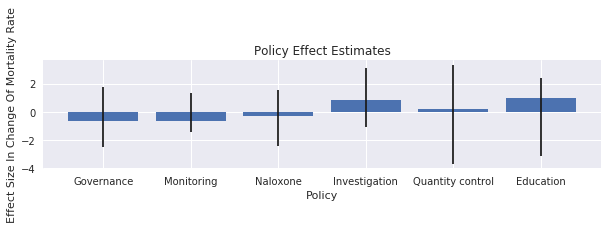

In [242]:
%matplotlib inline

import matplotlib.pyplot as plt

points = [point_estimates[policy] for policy in final_labels]
print(points)

policies = list(point_estimates.keys())

x = [bootstrap_estimates[policy] for policy in policies]

print (x[0])


alpha = 0.2

low = [
    np.percentile(bootstrap_estimates[policy], q=alpha/2 * 100) - np.median(bootstrap_estimates[policy])
    for policy in policies
]
high = [
    -(np.percentile(bootstrap_estimates[policy], q=(1 - alpha/2) * 100) - np.median(bootstrap_estimates[policy]))
    for policy in policies
]

print(policies)


medians = [
    np.median(bootstrap_estimates[policy]) for policy in policies
]

ind = np.arange(len(policies))

print(low)
print(high)
print(medians)
plt.figure(figsize=(10, 2))
plt.bar(ind, height=medians, yerr=[low, high])
plt.xlabel('Policy')
plt.ylabel('Effect Size In Change Of Mortality Rate')
plt.title('Policy Effect Estimates')

plt.xticks(ind, policies)

plt.savefig('policy_effects.png'.format(policy))